# Risk-targeted risk-parity portfolio: 

This document computes a similar diversified risk-targeted risk parity portfolio as the  [Man AHL TargetRisk](https://www.man.com/ahl-targetrisk) or [Ray Dalio's All weather portfolio](https://www.optimizedportfolio.com/all-weather-portfolio/). There are some key differences between each portfolio implementation, however, they both try to diversify, equalize the marginal risk contribution and rescale the portfolio to allow for a specific annualized risk level.  

Additional links:

https://portfolioslab.com/portfolio/ray-dalio-all-weather


https://info.recipeinvesting.com/t.pure.html



In [161]:
import yfinance as yf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import sympy as sp 
import seaborn as sns
import pyfolio as pf

### Portfolio approach and setup:

We have coded the risk-targeted risk-parity portfolio below. The covariance matrix is estimated in a simple manner: We employ the Exponentially Weighted Moving Average (EWMA) model with a pre-defined $\lambda = 0.94$ as is typically used under a daily sampled frequency. 

Note that, estimating the covariance matrix more accurately (eg. using a more sophisticated model) can lead to bigger annualized performance improvements over the long run. 


In [162]:
def Riskparity(Sigma, b, risktarget) -> dict:
    """
    Sigma: covariance matrix, 
    b: Risk contributions. For riskparity this should 1/n for n being amount of assets in universe. 
    risktarget: Insert risktarget and rescales portfolio. For annualized value then do risktarget * sqrt(252) using the square-root rule. 
    """ 
    import cvxpy as cp
    import sympy as sp 

    w = cp.Variable(Sigma.shape[0])  #portfolio weight
    obj = 0.5 * cp.quad_form(w, Sigma) - cp.sum(cp.multiply(b, cp.log(w)))  
    #objective
    constr = [w >= 0] 
    prob = cp.Problem(cp.Minimize(obj), constr)
    prob.solve()

    # normalize weights as provided in Palomar documentation: 
    w = w/cp.sum(w)

    portrisk = cp.sqrt(cp.quad_form(w, Sigma))
    alpha = risktarget / portrisk
    w_new = w * alpha
    b_new = cp.multiply(w_new, Sigma @ w_new) / cp.quad_form(w_new, Sigma)  #solution risk budget af rescaling


    portrisk_new = cp.sqrt(cp.quad_form(w_new, Sigma))
    x = sp.Symbol('x')
    LC_Weight = sp.solve(np.sum(w_new.value) - x - 1, x)[0] #In order to provide leverage, we need to loan money from elsewhere (ie. from shorting or loaning from the bank). This is the Leverage cost weight. 


    out = {"w_new": w_new.value, "w": w.value, "b_new": b_new.value, "LC_weight": LC_Weight, "portrisk": portrisk.value, "portrisk_new": portrisk_new.value}

    return(out)

def EWMA(returns, halflife = 20, lmb = None) -> np.array:
    """ Computes the simple multivariate Exponentially Weighted Moving Average estimator.

    Args:
        returns (np.array or dataframe): array or dataframe of returns
        lambda (float): Dampening/halflife factor. 
    """

    if lmb is None:
        lmb = np.exp(np.log(0.5)/halflife)

    covar = np.zeros((returns.shape[1], returns.shape[1], returns.shape[0]))


    #initiate covar using unconditional covariance: 

    covar[:,:,0] = returns.cov()

    for i in range(len(returns)-1):
        covar[:,:,i+1] = lmb * covar[:,:,i] + (1-lmb) * np.outer(returns.iloc[i,:],returns.iloc[i,:]) #returns.T @ returns

    return(covar)


def GMW_Weights(Cov) -> np.array:
    """Calculates the weights of the minimum variance portfolio using the closed-form solution. 

    Args:
        Cov (np.array): Covariance matrix

    Returns:
        np.array: weights for the GMV portfolio
    """
    v = np.ones(Cov.shape[0])

    num = np.dot(np.linalg.inv(Cov), v)
    den = np.dot(v.T ,np.dot(np.linalg.inv(Cov), v))
    w = num / den 
    return(w)


def Tangent_Weights(Cov, mu) -> np.array:
    """Calculates the weights of the Tangent portfolio using the closed-form solution

    Args:
        Cov (np.array): Covariance matrix
        mu  (np.array): Expected excess returns (mu - rf)

    Returns:
        np.array: Weights for the Tangent portfolio
    """
    v = np.ones(Cov.shape[0])

    num = np.dot(np.linalg.inv(Cov), mu)
    den = np.dot(v.T, num)

    w = num / den 
    return(w)


def Turnover(w) -> np.array:
    """Calculates the daily turnover as provided in De Miguels popular paper, 'Optimal Versus Naive Diversification:
       How Inefficient is the 1/N Portfolio Strategy?'. Be aware that his presentation is a rolling turnover. 

    Args:
        w (np.array): weights including the leverage constraints

    Returns:
        np.array: the turnover of the portfolio. 
    """
    res = np.squeeze(np.sum(np.abs(np.diff(w, axis=0)), axis = 1)) 

    return(res)


### Assets: 

The assets are selected in order to consider a diversifying portfolio that can withstand any exogenous crisis. Gold (GLD) and TIPS (TIP) is a good hedge against inflation, whereas Government bonds (TLT) and long-term corporate bonds (HYG) are a good hedge against crashes in the stock-market. 

The risk-parity seeks to equalize the risk-contribution, implying that it will allocate more capital towards bonds as opposed to stocks. 

We have further subtracted the risk-free rate in order to work with excess returns. We assume that the risk-free asset has zero variance, are uncorrelated with the
risky assets and have an annualized return following the yield to maturity of a 1-year treasury bill transformed from percentage annualized values to daily decimal-values by dividing with 100 * 360. 

In [163]:
tickers = ["SPY", "GLD", "TLT", "HYG", "TIP"] #Stocks, Gold, Longterm Treasuries, Corporate bonds (High Yield), Treasure inflation protected bonds (a bet on rising inflation).
data = []

Start = '2002-01-01'
End = '2022-04-01'


for i in tickers: 
    stockdata = yf.download(i, start = Start, end = End)[['Adj Close', 'Volume']]
    data.append(stockdata['Adj Close'])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [164]:
#360 day count & annualized. 
RiskFreeRate = yf.download('^TNX', start=Start, end=End)
RiskFreeRate = RiskFreeRate['Adj Close'].dropna()
rf = RiskFreeRate.apply(lambda x: x/360 )/100

DF = pd.DataFrame(data).T
DF.columns = tickers
DF = DF.dropna(axis = 0)
DF = pd.merge(DF, rf, how = 'inner', on = 'Date')
DF = DF.rename(columns={'Adj Close': 'RF'})

[*********************100%***********************]  1 of 1 completed


In [165]:
#Rule of thumb: For anything other than modelling, do NOT use percentage returns. 

DF_Returns = pd.DataFrame(DF.iloc[:,0:5].pct_change().dropna() * 100 , index=DF.index[1:], columns=DF.columns[0:5]).subtract(DF['RF'][1:] * 100, axis = 0) #Working with linear returns for portfolio modelling. 
DF_LOGReturns = pd.DataFrame(np.diff(np.log(DF.iloc[:,0:5]) * 100, axis =  0), index=DF.index[1:], columns=DF.columns[0:5]).subtract(np.log(1 + DF['RF'][1:]) * 100, axis = 0) #Percentage log-returns
DF_LOGReturns

,SPY,GLD,TLT,HYG,TIP
Date,,,,,
2007-04-12,0.430191,-0.147422,0.009732,0.053916,-0.013157
2007-04-13,0.442004,1.247637,-0.322622,-0.195328,-0.263031
2007-04-16,0.932034,0.808939,0.536344,-0.051573,0.306532
2007-04-17,0.252432,-0.599536,0.544754,-0.061023,0.046799
2007-04-18,0.109367,0.544337,0.485347,0.015902,0.315417
...,...,...,...,...,...
2022-03-25,0.480250,-0.417308,-1.403932,-0.729825,-0.692849
2022-03-28,0.701904,-1.844032,0.844463,0.618312,-0.118985
2022-03-29,1.222826,0.038002,0.745735,1.220026,-0.367861


### EWMA with half-life

We will be working with a half-life of 20 days, equivalent to one month in the stock market. The half-life is the time lag at which the exponential weights decay by one half:

$$
\lambda^{\tau} = \frac{1}{2}.
$$

Doing some rearranging, we get the following functions relations:

$$
\tau = \exp\left(\frac{\ln\left(\frac{1}{2}\right)}{\ln(\lambda)}\right), \qquad \lambda = \exp\left(\frac{\ln\left(\frac{1}{2}\right)}{\tau}\right). 
$$

When working with daily data, the half-life is denoted in days, ie. $\tau = 20$ implies 20 days, equivalent to 1-month half-life in the market. To see this, consider $\tau = 2$ then $\lambda = 0.707$ then: 

\begin{align}
\Sigma_{t-1} &= 0.707 \cdot \Sigma_{t-2} + (1-0.707) \cdot \hat{\Sigma}_{t-2}\\
\Sigma_{t} &= 0.707 \cdot \Sigma_{t-1} + (1-0.707) \cdot \hat{\Sigma}_{t-1} \\ 
&= 0.707 \left[ 0.707 \cdot \Sigma_{t-2} + (1-0.707) \cdot \hat{\Sigma}_{t-1}\right] + (1-0.707) \cdot \hat{\Sigma}_{t-1}\\
&\approxeq 0.5 \cdot \Sigma_{t-2} + 0.207 * \hat{\Sigma}_{t-1} + (1-0.707) \cdot \hat{\Sigma}_{t-1}.
\end{align}
So it is surely seen that the covariance estimate at $t-2$ is halfed when calculating $\Sigma_t$. 

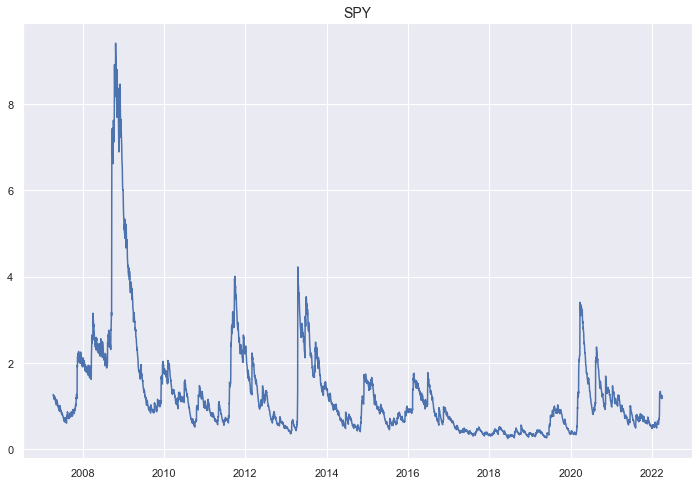

In [166]:
EWMALogreturns = EWMA(DF_LOGReturns, halflife=20)
EWMALinearreturns = EWMA(DF_Returns, halflife=20)

plt.figure(figsize = (12,8))
plt.plot(DF_LOGReturns.index, EWMALogreturns[1,1,:])
plt.title(DF_LOGReturns.columns[0], size = 14)
plt.show()

### Logreturns vs Linear returns

We know that $\log(1+x) \approx x$ when $x$ is small (start to deviate around 0.5). In many cases daily returns are small with the exception of when we experience exogenous market events. Therefore in many circumstances, it does not matter (completely) whether we use linear or logreturns. 

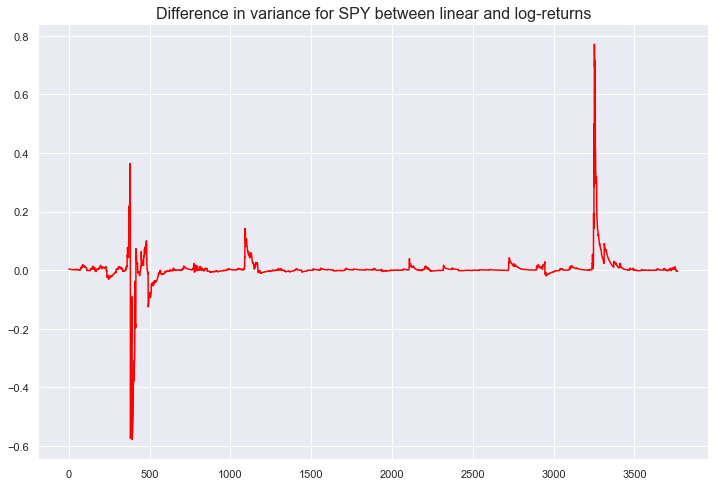

In [167]:
sns.set()
plt.figure(figsize=(12,8))
plt.plot(EWMALogreturns[0,0,:] - EWMALinearreturns[0,0,:], color = 'red')
plt.title('Difference in variance for SPY between linear and log-returns', size = 16)
plt.show()

#Makes sense since linear ret \approx 1 + log(logret). Only under 2008 and covid crisis, we observe a small difference.
#From now on we use log-returns for temporal modelling and linear returns for portfolio management. 

### Pseudo train-test split: 

Since we have fixed the half-life $\tau = 20$ days for simplicity, we do not work with any model optimization procedure. Thus, the train-test split procedure is not necessary. The reason it is done, is to compare the portfolio performance metrics on the test-set (out-of-sample) and not the entire sample.

In [168]:
# Redefine returns under a train test split. 
# There is no reason for a train test split on the EWMA model, since we have no parameter to estimate under the train set. 
# The focus will be on the portfolio and not the modelling. Thus we will observe how the all-weather portfolio fares with a simple EWMA model in the train set. 

#Calculating excess linear and log-returns by subtracting the risk-free rate. 

LogDF = pd.DataFrame(np.diff(np.log( DF.iloc[:,0:5]), axis = 0), index = DF.index[1:], columns = DF.columns[0:5]).subtract(np.log(1 + DF['RF'][1:]), axis = 0)
LinDF = pd.DataFrame(DF.iloc[:,0:5].pct_change().dropna() , index=DF.index[1:], columns=DF.columns[0:5]).subtract(DF['RF'][1:], axis = 0)


TrainLogReturns, TestLogReturns = train_test_split(LogDF, test_size = 0.2, shuffle = False)

TrainLinReturns, TestLinReturns = train_test_split(LogDF, test_size = 0.2, shuffle = False)


#TrainLogReturns = pd.DataFrame(np.diff(np.log(TrainDF.iloc[:,0:5]), axis =  0), index=TrainDF.index[1:], columns=TrainDF.columns[0:5]).subtract(np.log(1 + TrainDF['RF'][1:]), axis = 0)
TrainLinReturns = pd.DataFrame(TrainDF.iloc[:,0:5].pct_change().dropna() , index=TrainDF.index[1:], columns=TrainDF.columns[0:5]).subtract(TrainDF['RF'][1:], axis = 0)

#TestLogReturns = pd.DataFrame(np.diff(np.log(TestDF.iloc[:,0:5]), axis =  0), index=TestDF.index[1:], columns=TestDF.columns[0:5]).subtract(np.log(1 + TestDF['RF'][1:]), axis = 0)
TestLinReturns = pd.DataFrame(TestDF.iloc[:,0:5].pct_change().dropna() , index=TestDF.index[1:], columns=TestDF.columns[0:5]).subtract(TestDF['RF'][1:], axis = 0)

RFLinRetTrain, RFLinRetTest = train_test_split(DF['RF'], test_size = 0.2, shuffle = False)

#re-add DF: 

TrainLinReturns = pd.merge(TrainLinReturns, RFLinRetTrain, how = 'inner', on = 'Date')
TestLinReturns = pd.merge(TestLinReturns, RFLinRetTest, how = 'inner', on = 'Date')

LinDF = pd.merge(LinDF, DF['RF'], how = 'inner', on = 'Date')

In [169]:
EWMATrain = EWMA(LogDF, halflife=20)

Weights = np.zeros((5, EWMATrain.shape[2]))
WeightsScaled = np.zeros((5, EWMATrain.shape[2]))
LC_weights = np.zeros(EWMATrain.shape[2])
PortfolioRisk = np.zeros(EWMATrain.shape[2])
PortfolioRiskScaled = np.zeros(EWMATrain.shape[2])


b = np.ones(EWMATrain.shape[0])/EWMATrain.shape[0]
for i in range(EWMATrain.shape[2]):
    temp = Riskparity(EWMATrain[:,:,i], b, 0.1/np.sqrt(252)) #if we want 0.1 (10%) annualized volatility then we need to downscale it to daily, 0.1/np.sqrt(252)?

    WeightsScaled[:,i] = temp['w_new']
    Weights[:,i] = temp['w']
    LC_weights[i] = temp['LC_weight']
    PortfolioRisk[i] = temp['portrisk']
    PortfolioRiskScaled[i] = temp['portrisk_new']

    
Weights = pd.DataFrame(Weights.T, index = LogDF.index, columns=LogDF.columns.values)
WeightsScaled = pd.DataFrame(WeightsScaled.T, index = LogDF.index, columns=LogDF.columns.values)
LC_weights = pd.DataFrame(LC_weights.T, index = LogDF.index)
LC_weights = LC_weights.rename(columns={0: 'RF'})
#Note to self: internal sympy solver slows down computation, from 41s -> 2m10s  

c:\ProgramData\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [170]:
# first and foremost disregard leverage cost and then model everything else. 
# be aware that leveraged asset should have no volatility as it should be risk-free. --> long-term treasuries or bank account. 
# Transaction cost can simplitically be calculated by some percentage of daily turnover. 

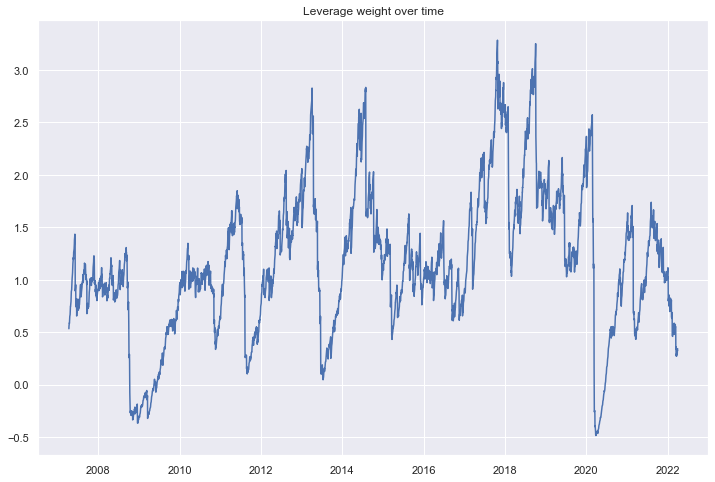

In [171]:
sns.set()
plt.figure(figsize=(12,8))
plt.plot(LogDF.index, LC_weights)
plt.title('Leverage weight over time')
plt.show()
#There is a considerable leverage in the portfolio under a 10% annualized volatility target. 

### Rebalancing: 

The rebalancing methodology is done in a non-conventional manner: We assume that we still have daily data available, but only rebalace each week/month in order to save on friction costs. That way, we still want to utilize as much information as possible, thus fitting the model on daily stock data. 

Transaction costs will be 0.5% of the daily turnover.  

In [172]:
#We need the turnover for all assets we invest in or borrow from. Nothing is free. 
# We will work with proportional transaction costs as done in De Miguel paper. 

# Daily rebalancing
CollectedWeights = pd.concat([WeightsScaled, LC_weights], axis = 1)
TurnoverLevRiskParity = Turnover(WeightsScaled)
TurnoverRiskParity = Turnover(Weights)


# "Weekly rebalancing", converted back into daily dates. Weights are repeated until they are updated each week: 
#.ffill() is forward fill and fills out all nan values forward until new value arrives eg. [1, na, na, 2, na, na].ffill() = [1,1,1,2,2,2]
CollectedWeights_weekly = pd.concat([WeightsScaled.resample('w').last(), LC_weights.resample('w').last()], axis = 1).resample('D').last().ffill()
TurnoverLevRiskParity_weekly = Turnover(WeightsScaled.resample('w').last().resample('D').last().ffill())

Weights_weekly = Weights.resample('w').last().resample('D').last().ffill()
TurnoverRiskParity_weekly = Turnover(Weights_weekly)


# "Monthly rebalancing": 
CollectedWeights_monthly = pd.concat([WeightsScaled.resample('M').last(), LC_weights.resample('M').last()], axis = 1).resample('D').last().ffill()
TurnoverLevRiskParity_monthly = Turnover(WeightsScaled.resample('M').last().resample('D').last().ffill())

Weights_monthly = Weights.resample('M').last().resample('D').last().ffill()
TurnoverRiskParity_monthly = Turnover(Weights_monthly)



In [173]:
#portfolio returns can now be calculated (net of transaction cost) as: r_t = w^T * r_t^e - c * TO_t, where r_t^e is the excess return.

# Transaction cost
c = 0.005 # 50 bp in De Miguel


PortReturnsLevRiskParity = np.zeros(LinDF.shape[0])
PortReturnsRiskParity = np.zeros(LinDF.shape[0])

PortReturnsLevRiskParity_weekly = np.zeros(LinDF.shape[0])
PortReturnsRiskParity_weekly = np.zeros(LinDF.shape[0])

PortReturnsLevRiskParity_monthly = np.zeros(LinDF.shape[0])
PortReturnsRiskParity_monthly = np.zeros(LinDF.shape[0])



#Scaling returns as done in Volatility targeting, 

#daily rebalancing
for i in range(LinDF.shape[0]-1):
    PortReturnsLevRiskParity[i] = np.subtract(np.dot(CollectedWeights.iloc[i,:], LinDF.iloc[i,:]), c * TurnoverLevRiskParity[i])
    PortReturnsRiskParity[i] = np.subtract(np.dot(Weights.iloc[i,:], LinDF.iloc[i,0:5]), c * TurnoverRiskParity[i]) #LinDF.iloc[i,0:5]

#weekly rebalancing
for i in range(LinDF.shape[0]-1):
    PortReturnsLevRiskParity_weekly[i] = np.subtract(np.dot(CollectedWeights_weekly.iloc[i,:], LinDF.iloc[i,:]), c * TurnoverLevRiskParity_weekly[i])
    PortReturnsRiskParity_weekly[i] = np.subtract(np.dot(Weights_weekly.iloc[i,:], LinDF.iloc[i,0:5]), c * TurnoverRiskParity_weekly[i]) 

#monthly rebalancing:
for i in range(LinDF.shape[0]-1):
    PortReturnsLevRiskParity_monthly[i] = np.subtract(np.dot(CollectedWeights_monthly.iloc[i,:], LinDF.iloc[i,:]), c * TurnoverLevRiskParity_monthly[i])
    PortReturnsRiskParity_monthly[i] = np.subtract(np.dot(Weights_monthly.iloc[i,:], LinDF.iloc[i,0:5]), c * TurnoverRiskParity_monthly[i]) 




The plot below, give us an indication that rebalancing the risk-targeted portfolio on a monthly basis leads to higher annualized compounded returns. If there were no friction costs, then the risk-targeted portfolio on a daily rebalancing frequency yields much better results. 

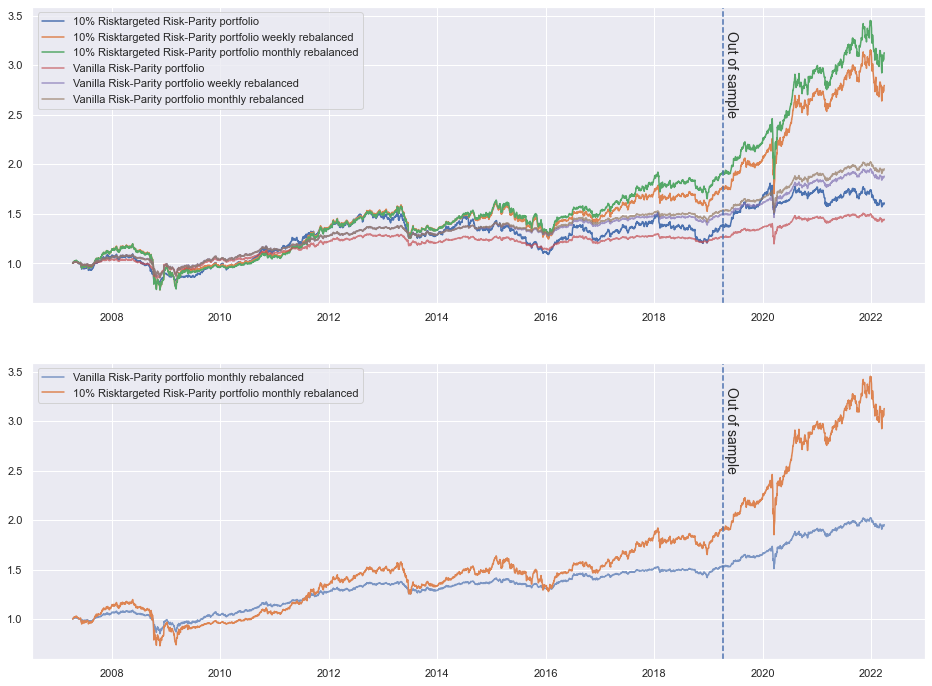

In [174]:
#limitations on investing in the riskfree asset. Turnover is only calculated on risky assets, aka not the riskfree rate. 

#Cumulative returns is the same as the wealth function (16) defined in DeMiguels paper (this has been tested)
CumRetLevRiskParity = pd.DataFrame((1 + PortReturnsLevRiskParity).cumprod(), index = LinDF.index)
CumRetRiskParity = pd.DataFrame((1 + PortReturnsRiskParity).cumprod(), index = LinDF.index)
CumRetRiskParity_weekly = pd.DataFrame((1 + PortReturnsRiskParity_weekly).cumprod(), index = LinDF.index) 
CumRetRiskParity_monthly = pd.DataFrame((1 + PortReturnsRiskParity_monthly).cumprod(), index = LinDF.index) 
CumRetLevRiskParity_weekly = pd.DataFrame((1 + PortReturnsLevRiskParity_weekly).cumprod(), index = LinDF.index)
CumRetLevRiskParity_monthly = pd.DataFrame((1+PortReturnsLevRiskParity_monthly).cumprod(), index = LinDF.index)


fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16,12))
ax[0].plot(CumRetLevRiskParity, label = '10% Risktargeted Risk-Parity portfolio')
ax[0].plot(CumRetLevRiskParity_weekly, label = '10% Risktargeted Risk-Parity portfolio weekly rebalanced')
ax[0].plot(CumRetLevRiskParity_monthly, label = '10% Risktargeted Risk-Parity portfolio monthly rebalanced')
ax[0].plot(CumRetRiskParity, label = 'Vanilla Risk-Parity portfolio', alpha = 0.7)
ax[0].plot(CumRetRiskParity_weekly, label = 'Vanilla Risk-Parity portfolio weekly rebalanced', alpha = 0.7)
ax[0].plot(CumRetRiskParity_monthly, label = 'Vanilla Risk-Parity portfolio monthly rebalanced', alpha = 0.7)
ax[0].axvline(x = TestLinReturns.index[0], linestyle = '--')
ax[0].text(x = TestLinReturns.index[5], y = 2.5, s = 'Out of sample', rotation = -90, size = 14)
ax[0].legend()

ax[1].plot(CumRetRiskParity_monthly, label = 'Vanilla Risk-Parity portfolio monthly rebalanced', alpha = 0.7)
ax[1].plot(CumRetLevRiskParity_monthly, label = '10% Risktargeted Risk-Parity portfolio monthly rebalanced')
ax[1].axvline(x = TestLinReturns.index[0], linestyle = '--')
ax[1].text(x = TestLinReturns.index[5], y = 2.5, s = 'Out of sample', rotation = -90, size = 14)
ax[1].legend()

plt.show()


The ex-post realized volatility for the monthly rebalaced portfolio have a hard time targeting 10% annualized volatility. A few reasons might be: 

1. The volatility model is not accurate. Using intraday data to procure better covariance forecasts have increased benefits in better targeting.
2. The rebalancing is too infrequent, making it hard for the portfolio to target the annualized volatility. 

Rebalancing daily definitely seems to have the effect of better targeting the annualized volatility estimate. 

<Figure size 1152x720 with 0 Axes>

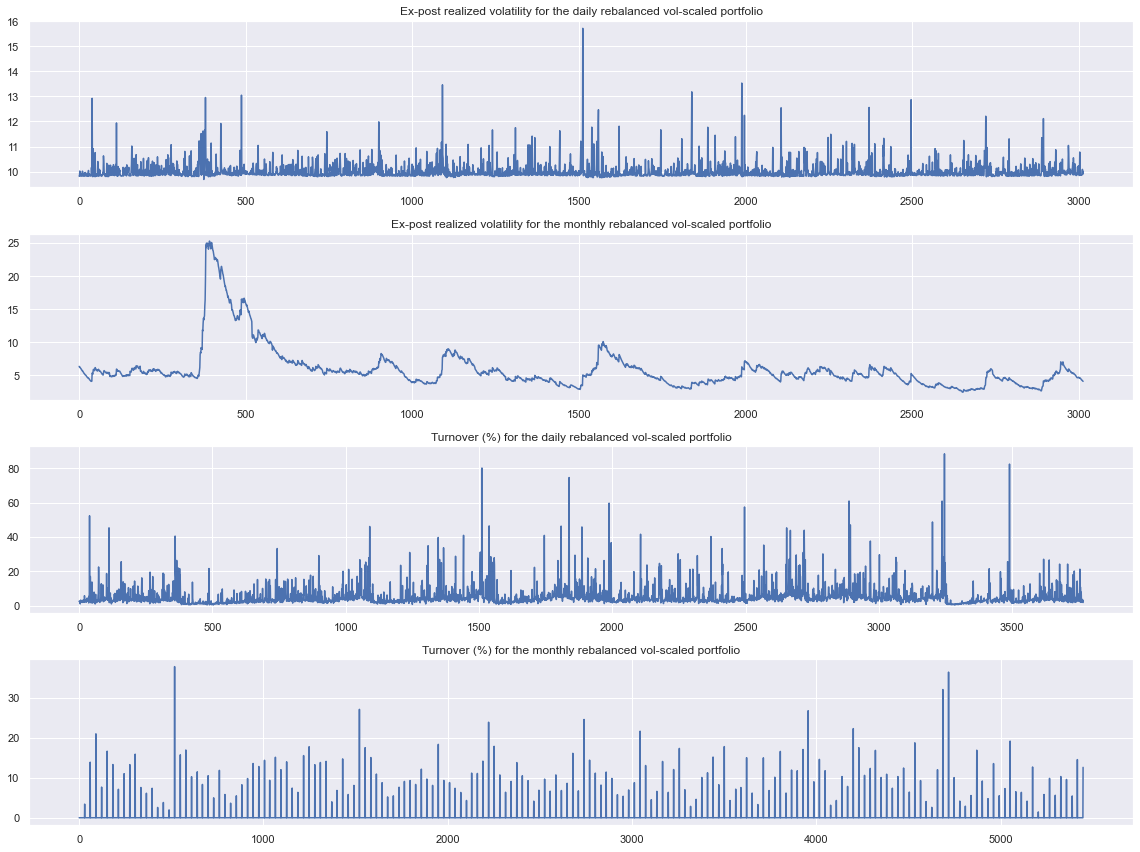

In [175]:

#this is not the right portfolio risk. Comes after the rebalancing. w_t^T * sigma_t+1 w_t

#Ex-post realized portfolio risk: 
plt.figure(figsize=(16,10))

RealizedVolatility = np.zeros(TrainLinReturns.shape[0]-1)
RealizedVolatilityMonthly = np.zeros(TrainLinReturns.shape[0]-1)
RealizedVolatilityWeekly = np.zeros(TrainLinReturns.shape[0]-1)


for i in range(TrainLinReturns.shape[0]-1):
    RealizedVolatility[i] = np.sqrt(np.dot(WeightsScaled.iloc[i,:].T, np.dot(EWMALinearreturns[:,:,i+1], WeightsScaled.iloc[i,:]))) 
    RealizedVolatilityWeekly[i] = np.sqrt(np.dot(Weights_weekly.iloc[i,:].T, np.dot(EWMALinearreturns[:,:,i+1], Weights_weekly.iloc[i,:]))) 
    RealizedVolatilityMonthly[i] = np.sqrt(np.dot(Weights_monthly.iloc[i,:].T, np.dot(EWMALinearreturns[:,:,i+1], Weights_monthly.iloc[i,:]))) 


fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(16,12))
ax[0].plot(RealizedVolatility * np.sqrt(252))
ax[0].set_title('Ex-post realized volatility for the daily rebalanced vol-scaled portfolio')
ax[1].plot(RealizedVolatilityMonthly * np.sqrt(252))
ax[1].set_title('Ex-post realized volatility for the monthly rebalanced vol-scaled portfolio')
ax[2].plot(TurnoverLevRiskParity * 100)
ax[2].set_title('Turnover (%) for the daily rebalanced vol-scaled portfolio')
ax[3].plot(TurnoverRiskParity_monthly * 100)
ax[3].set_title('Turnover (%) for the monthly rebalanced vol-scaled portfolio')


plt.tight_layout()
plt.show()


One key thing to observe below, is how the portfolio downscales all of the weights around the Covid outbreak in 2020. Apparently, cross market volatility (possibly due to risk-spillover effects) was high enough to downscale all asset classes. Without any further investigation, this could also be evidence of the weakness of a vol-scaled risk-parity portfolio: It runs on the notion that all volatility should be treated equally. However, TLT and GLD being safehaven assets will, in times of crisis,  exhibit increased volatility with corresponding positive returns, as a reaction to the crisis (the reaction might be lagged).  Thus disentangling the volatility into positive and negative semivariance might be a viable option for the risk-parity portfolio. 

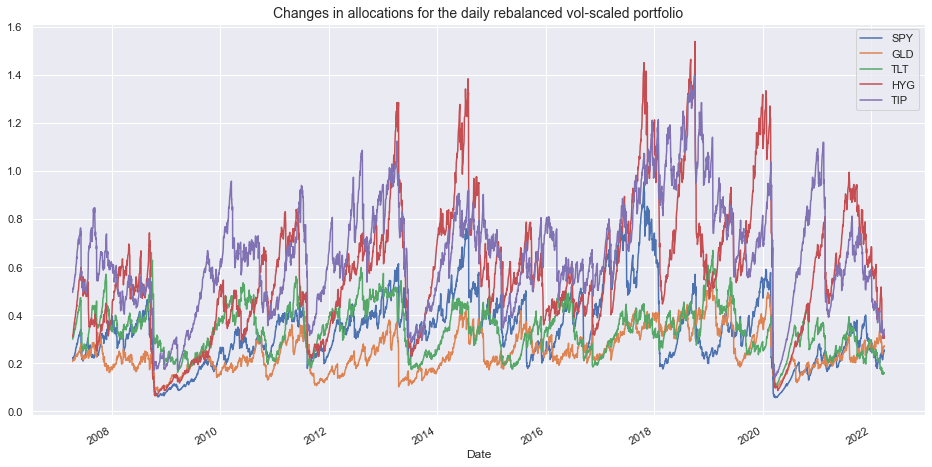

In [176]:
WeightsScaled.plot(figsize=(16,8), label ="Changes in allocations for the daily rebalanced vol-scaled portfolio")
plt.title('Changes in allocations for the daily rebalanced vol-scaled portfolio', size = 14)
plt.show()

We look at the performance summary of the vol-scaled monthly rebalanced portfolio against the monthly rebalanced risk-parity portfolio.

                    Strategy
------------------  ----------
Start Period        2019-04-08
End Period          2022-03-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   63.26%
CAGR﹪              17.87%

Sharpe              1.12
Prob. Sharpe Ratio  96.95%
Sortino             1.55
Sortino/√2          1.09
Omega               1.23

Max Drawdown        -24.73%
Longest DD Days     121

Gain/Pain Ratio     0.23
Gain/Pain (1M)      1.56

Payoff Ratio        0.9
Profit Factor       1.23
Common Sense Ratio  1.2
CPC Index           0.64
Tail Ratio          0.98
Outlier Win Ratio   3.65
Outlier Loss Ratio  4.11

MTD                 -0.31%
3M                  -9.36%
6M                  0.82%
YTD                 -9.35%
1Y                  11.73%
3Y (ann.)           17.95%
5Y (ann.)           17.87%
10Y (ann.)          17.87%
All-time (ann.)     17.87%

Avg. Drawdown       -2.34%
Avg. Drawdown Days  19
Recovery Factor     2.56
Ulcer Index         0.05
Serenity Index      1.

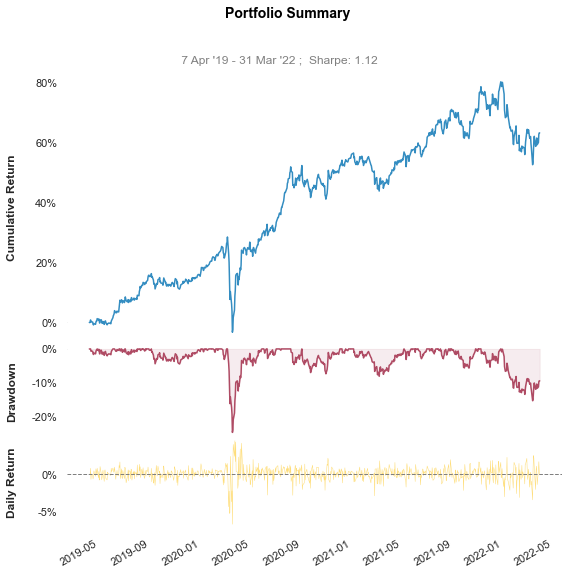

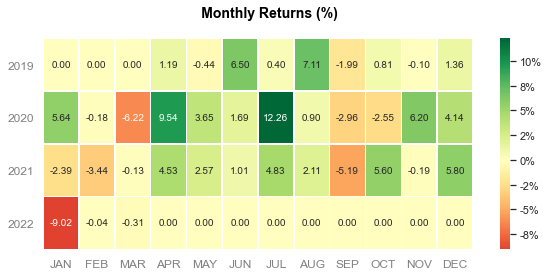

In [177]:
import quantstats as qs

# do it on testset linreturns only. 

PortReturnsLevRiskParity_monthly_Series = pd.Series(PortReturnsLevRiskParity_monthly, index = LinDF.index).loc[TestLinReturns.index[0]:, ]
qs.reports.basic(PortReturnsLevRiskParity_monthly_Series)


                    Strategy
------------------  ----------
Start Period        2019-04-08
End Period          2022-03-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   27.3%
CAGR﹪              8.44%

Sharpe              1.13
Prob. Sharpe Ratio  97.09%
Sortino             1.57
Sortino/√2          1.11
Omega               1.24

Max Drawdown        -12.96%
Longest DD Days     120

Gain/Pain Ratio     0.24
Gain/Pain (1M)      1.65

Payoff Ratio        0.91
Profit Factor       1.24
Common Sense Ratio  1.21
CPC Index           0.65
Tail Ratio          0.98
Outlier Win Ratio   3.69
Outlier Loss Ratio  3.82

MTD                 -0.15%
3M                  -3.42%
6M                  0.49%
YTD                 -3.41%
1Y                  5.71%
3Y (ann.)           8.51%
5Y (ann.)           8.44%
10Y (ann.)          8.44%
All-time (ann.)     8.44%

Avg. Drawdown       -1.12%
Avg. Drawdown Days  18
Recovery Factor     2.11
Ulcer Index         0.02
Serenity Index      1.65


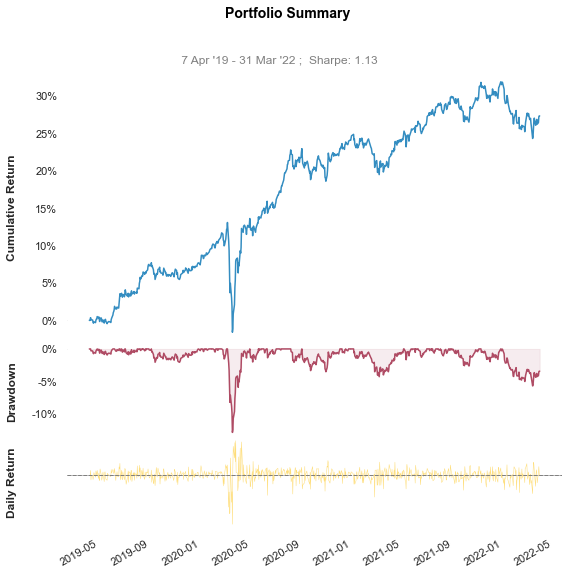

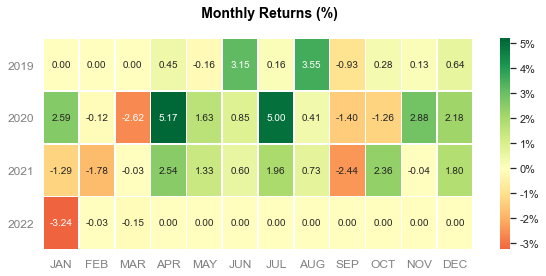

In [178]:
PortReturnsRiskParity_monthly_Series = pd.Series(PortReturnsRiskParity_monthly, index = LinDF.index).loc[TestLinReturns.index[0]:, ]
qs.reports.basic(PortReturnsRiskParity_monthly_Series)